# LSTM Analysis 

Long Short-Term Memory (LSTM) networks, a special kind of Recurrent Neural Network (RNN), have emerged as a powerful tool for predicting time series data due to their ability to capture long-term dependencies and patterns. Unlike traditional neural networks, LSTMs can remember information over extended periods, making them particularly suitable for applications where historical context significantly influences future outcomes. This capability is especially valuable in financial markets, where past stock prices and trends can provide insightful cues for future movements.

In this analysis, we leverage the strengths of LSTM networks to predict the stock price of the Vanguard S&P 500 ETF ($VOO)



### 0. Importing Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import seaborn as sns

import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### 1. Data Preparation & Preprocessing



In [3]:
voo_data = pd.read_csv('../datasets/VOO_full.csv')
df = pd.read_csv('../datasets/VOO_full.csv')
display(voo_data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-01,354.549988,359.390015,354.500000,358.119995,340.781616,3721100
1,2021-03-02,358.380005,358.630005,355.160004,355.350006,338.145752,5462600
2,2021-03-03,354.700012,355.640015,350.559998,350.660004,333.682800,6317600
3,2021-03-04,350.489990,353.019989,341.920013,346.339996,329.571930,6604500
4,2021-03-05,349.769989,353.730011,342.589996,352.690002,335.614471,8721300
...,...,...,...,...,...,...,...
771,2024-03-22,479.869995,480.320007,478.820007,479.179993,479.179993,5876800
772,2024-03-25,477.730011,478.790009,477.549988,477.940002,477.940002,6081300
773,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500
774,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400


In [4]:
# Convert the 'Date' column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Now, focus on the 'Close' column
df_close = df[['Close']]
df_close

,Close
Date,
2021-03-01,358.119995
2021-03-02,355.350006
2021-03-03,350.660004
2021-03-04,346.339996
2021-03-05,352.690002
...,...
2024-03-22,479.179993
2024-03-25,477.940002
2024-03-26,476.600006


### 2. Exploratory Data Analysis


In [5]:
#Summary Statistics
print(voo_data.describe())

             Open        High         Low       Close   Adj Close  \
count  776.000000  776.000000  776.000000  776.000000  776.000000   
mean   394.096753  396.413247  391.684588  394.226392  384.298414   
std     30.896275   30.462754   31.278122   30.913516   32.345366   
min    320.839996  330.579987  319.869995  327.640015  319.887482   
25%    370.890015  373.555001  367.797485  371.182503  360.895416   
50%    392.834992  394.875000  391.120011  393.509995  382.577424   
75%    413.307510  415.125008  411.475013  413.692504  402.873253   
max    482.619995  483.239990  481.209991  481.350006  480.760010   

             Volume  
count  7.760000e+02  
mean   4.837919e+06  
std    2.185098e+06  
min    1.351300e+06  
25%    3.417675e+06  
50%    4.278250e+06  
75%    5.576350e+06  
max    2.297070e+07  


In [6]:
# Check for Missing Values
print(voo_data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


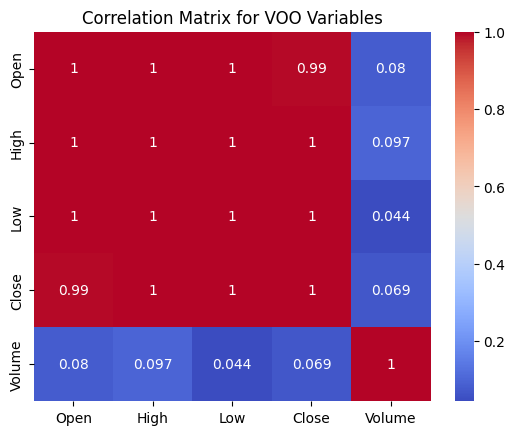

In [7]:
# Correlation Matrix
correlation_matrix = voo_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for VOO Variables')
plt.show()

From this heatmap, we can conclude that the Open, High, Low, and Close values are highly correlated with each other for VOO, meaning they tend to move together during the trading period. However, Volume does not strongly correlate with price movement, indicating that for VOO, volume changes are not necessarily associated with large changes in price. This can be useful information for trading strategies that might, for example, use volume as an indicator independent of price movements.

---

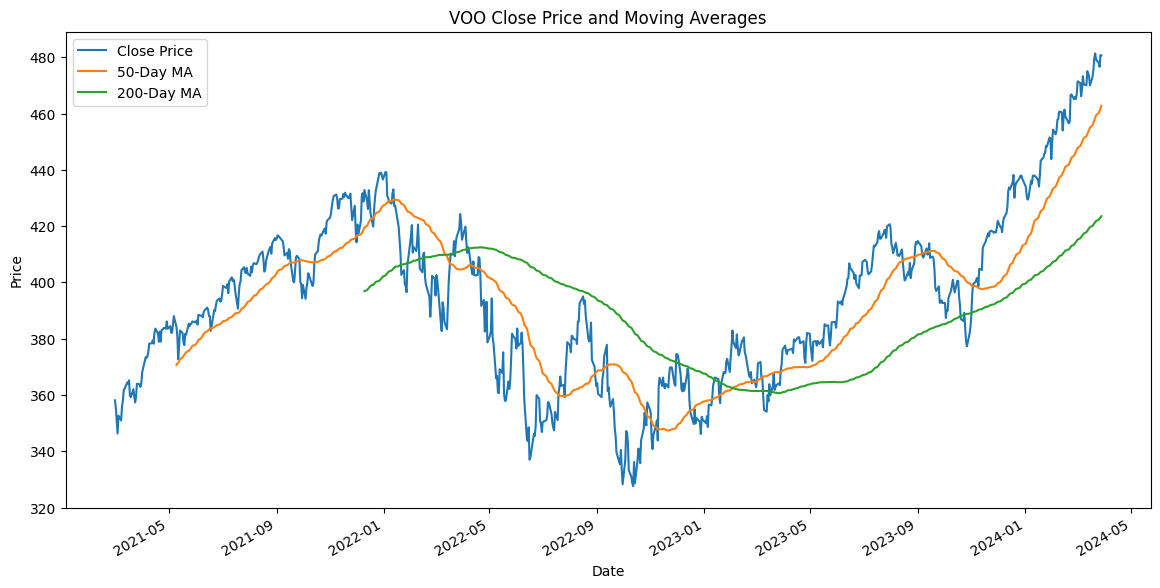

In [8]:
# Closing Price and Moving Averages on One Chart

plt.figure(figsize=(14, 7))

# Plotting the Closing Price
df['Close'].plot(label='Close Price')

# Short-term (50-day) and Long-term (200-day) Moving Averages
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()
df['MA50'].plot(label='50-Day MA')
df['MA200'].plot(label='200-Day MA')

plt.title('VOO Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In the chart, the MA200 starts later than the MA50 (50-day moving average) and the closing price line. This happens because a 200-day moving average requires 200 days of data before the first value can be calculated. Therefore, the MA200 line will begin to appear on the chart only after the first 200 days.

The 200-day moving average is used to determine the long-term market trend and smooth out price fluctuations. It's slower to respond to price changes than the 50-day moving average because it considers a larger set of data, which is why it appears smoother and starts later in the chart.

The overall chart shows the closing price of VOO, along with the short-term (MA50) and long-term (MA200) trends. The MA50 line reacts more quickly to recent price changes, while the MA200 provides a more gradual trend line that reflects longer-term price movements. When the closing price dips below these averages, it could be seen as a bearish signal, and when it's above, it could be bullish. The intersection points where the closing price or MA50 crosses the MA200 can be of particular interest to traders looking for trend reversals.

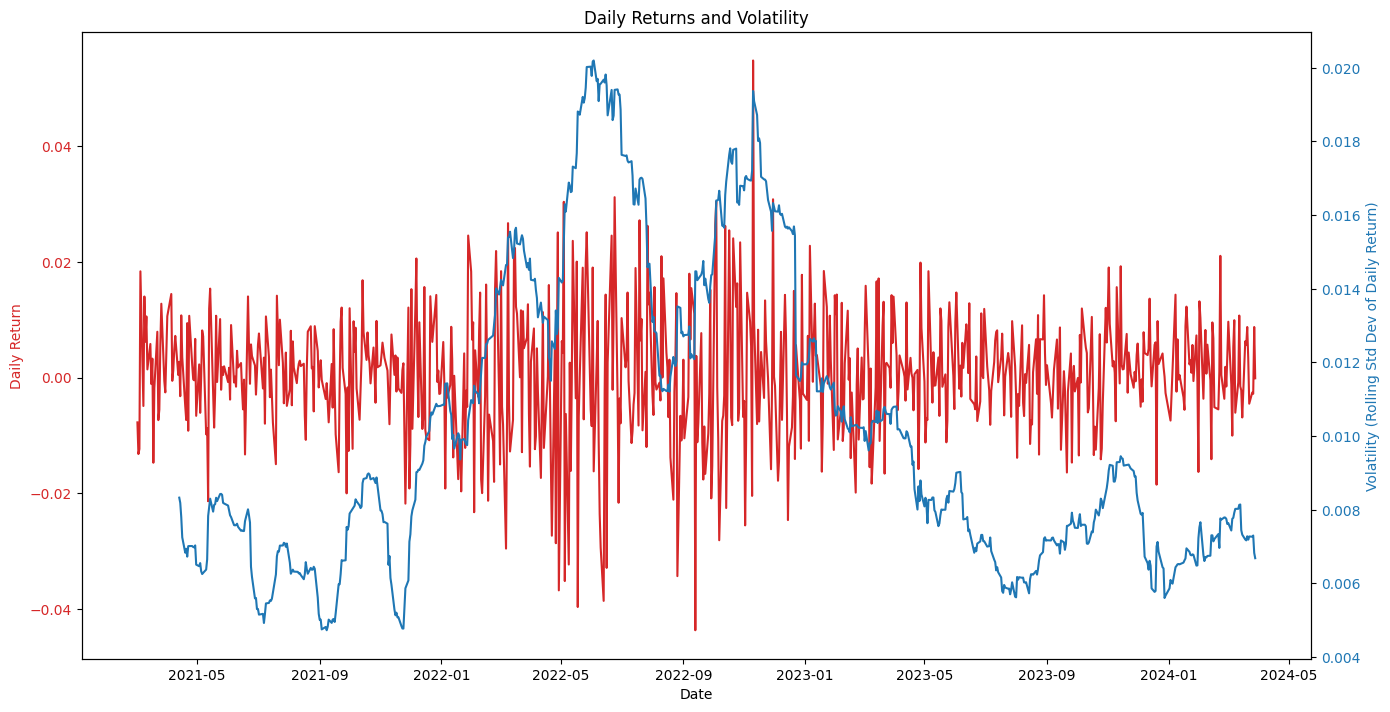

In [9]:
# Daily Returns and Volatility in a Single Chart
df['Daily Return'] = df['Close'].pct_change()

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return', color=color)
ax1.plot(df.index, df['Daily Return'], color=color, label='Daily Return')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Volatility (Rolling Std Dev of Daily Return)', color=color)  
ax2.plot(df.index, df['Daily Return'].rolling(window=30).std(), color=color, label='Rolling 30-Day Std Dev')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Daily Returns and Volatility')
plt.show()


When 

---


### 3. Training Set Preparation and Data Normalisation

In [10]:
train_df = df_close[:'2023-02-28']  # Training data until end of February 2023
test_df = df_close['2023-03-01':] # Test data starting from March 2023

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_df['Close'].values.reshape(-1,1))

# Prepare the training data with a specified number of days to use for the prediction
N_PRED_DAYS = 50
x_train, y_train = [], []

for d in range(N_PRED_DAYS, len(scaled_train_data)):
    x_train.append(scaled_train_data[d - N_PRED_DAYS:d, 0])
    y_train.append(scaled_train_data[d, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

---

### 4. LSTM Model Building & Training

In [18]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

c:\Users\TAN UEI HORNG\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Training

In [19]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=35, batch_size=32)

Epoch 1/35


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1559
Epoch 2/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0344
Epoch 3/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0218
Epoch 4/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0174
Epoch 5/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0166
Epoch 6/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0155
Epoch 7/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0129
Epoch 8/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0137
Epoch 9/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0148
Epoch 10/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0132
Epoch 11/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0116
Epoch 12/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0120
Epoch 13/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0120
Epoch 14/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0118
Epoch 15/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0104
Epoch 16/35
15/

---

### 5. Predictions and Visualization

In [21]:
# Prepare the test data for predictions
test_data = test_df['Close'].values
model_inputs = np.concatenate((scaled_train_data[-N_PRED_DAYS:], scaler.transform(test_data.reshape(-1, 1))))
x_test = []

for d in range(N_PRED_DAYS, len(model_inputs)):
    x_test.append(model_inputs[d-N_PRED_DAYS:d, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict the stock prices using the test data
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Align predicted prices with the test data dates for plotting
predicted_dates = test_df.index[N_PRED_DAYS:]




10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


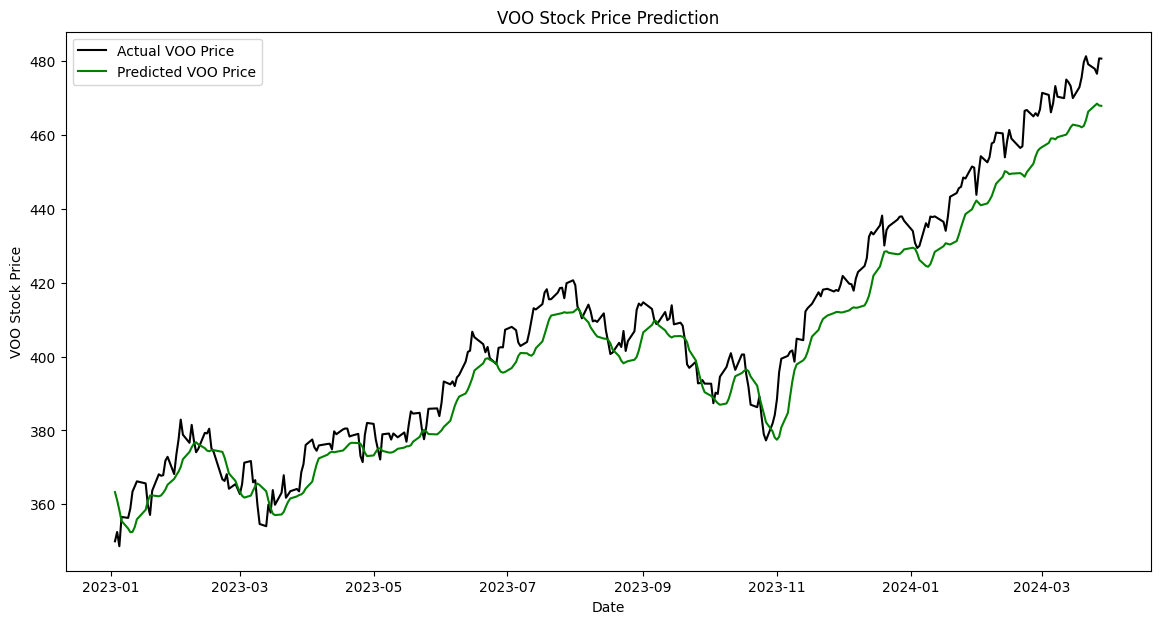

In [33]:
plt.figure(figsize=(14,7))
plt.plot(dates, actual_prices, color='black', label='Actual VOO Price')
plt.plot(dates, predicted_prices, color='green', label='Predicted VOO Price')
plt.title('VOO Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('VOO Stock Price')
plt.legend()
plt.show()

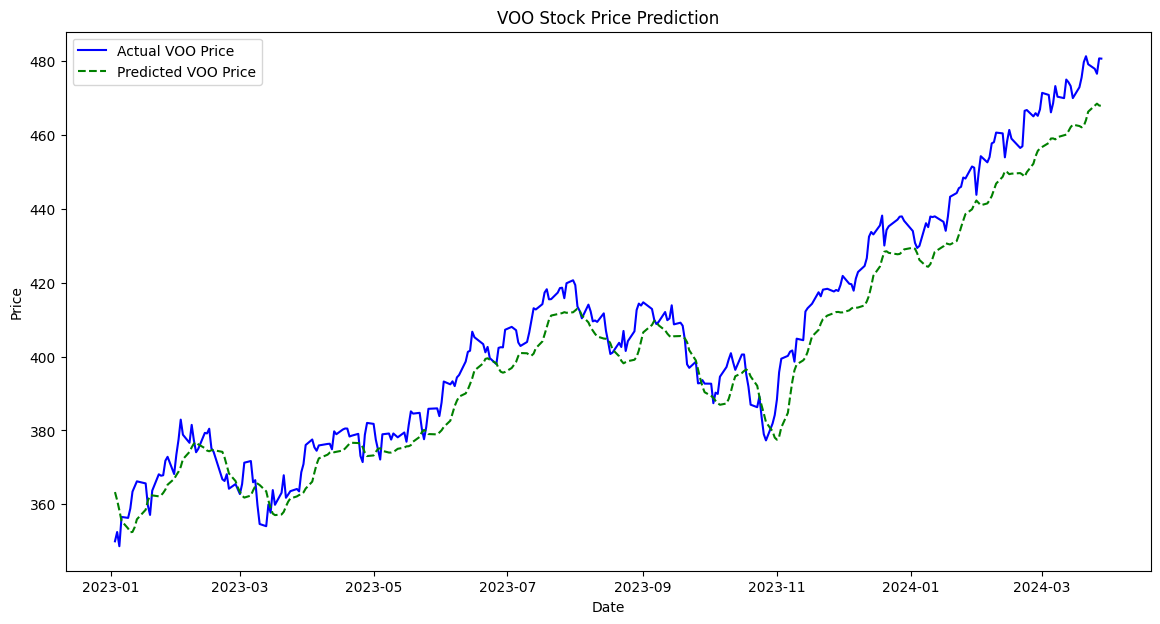

In [34]:

plt.show()
plt.figure(figsize=(14,7))
plt.plot(dates, actual_prices, color='blue', linestyle='-', label='Actual VOO Price')
plt.plot(dates, predicted_prices, color='green', linestyle='--', label='Predicted VOO Price')
plt.title('VOO Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### 6. Evaluation & Observation

In [41]:

# If actual_prices or predicted_prices are not already NumPy arrays, convert them:
# actual_prices = np.array(actual_prices)
# predicted_prices = np.array(predicted_prices)

# Check the shape of the arrays
print("Shape of actual_prices:", actual_prices.shape)
print("Shape of predicted_prices:", predicted_prices.shape)

# If predicted_prices is a 2D array with only one column (e.g., shape is (n_samples, 1)), flatten it
if len(predicted_prices.shape) == 2 and predicted_prices.shape[1] == 1:
    predicted_prices = predicted_prices.flatten()

# Check the shape again to ensure they match
print("New shape of predicted_prices:", predicted_prices.shape)

# Now you can safely compute the MSE
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error (MSE): {mse:.2f}")


Shape of actual_prices: (311,)
Shape of predicted_prices: (311, 1)
New shape of predicted_prices: (311,)
Mean Squared Error (MSE): 63.41


In [46]:
# Calculate the errors (residuals)
errors = actual_prices - predicted_prices

# Calculate the standard deviation of the errors
std_deviation = np.std(errors)

# Calculate the error as a percentage of the actual prices
error_percentage = (errors / actual_prices) * 100

# Calculate the mean of the absolute error percentages to get the MAPE
mape = np.mean(np.abs(error_percentage))

# Print out the metrics
print(f"Standard Deviation of Prediction Errors: {std_deviation:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Standard Deviation of Prediction Errors: 5.53
Mean Absolute Percentage Error (MAPE): 1.64%


In [ ]:
# Assuming MSE is a single numeric value and not an array
mse = 63.41  # Your MSE value
rmse = np.sqrt(mse)  # Calculate the RMSE
mean_price = np.mean(actual_prices)  # Ensure actual_prices is a NumPy array
rmse_percent_of_mean = (rmse / mean_price) * 100  # Calculate the percentage

# Use .format() method for compatibility
print("RMSE as a percentage of the mean VOO price: {:.2f}%".format(rmse_percent_of_mean))



RMSE as a percentage of the mean VOO price: 1.96%


In [52]:
from sklearn.metrics import r2_score

# Ensure actual_prices and predicted_prices are NumPy arrays. If they're not, convert them.
# If predicted_prices is 2D, flatten it: predicted_prices = predicted_prices.flatten()

# Calculate the R² score
r2 = r2_score(actual_prices, predicted_prices)

# Print the R² score
print(f"R² Score: {r2:.4f}")


R² Score: 0.9406


---